In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
matplotlib.rcParams['figure.figsize'] = (14, 10)

## The holdout validation method

One of the main tasks in developing and deploying a Machine Learning algorithm is model selection.
Given a ML problem (say, regression) how do we choose the most appropriate model?
That is, how can we select the model that is likely to give the lowest error on new predictions?
For a task as prevalent in real-world applications as regression, there are many possible models at our disposal:
are we going to stick with linear regression? should we introduce polynomial terms? should we add regularisation? of what type? Ridge? LASSO? or is a regression tree better suited?
To answer these questions we need to find a way to estimate the error that these models will have on data they have not yet seen.

One possible approach is to divide the data at our disposal into two sets: the training set and the test set.
We will use the test set as a proxy for new, unseen real data.
In a typical approach, then:
* The training set is used to *train* the model.
This means to find a good parametrisation for it and is accomplished by choosing the parameters which minimise a loss function over the training set.
For example, for a regression problem, we can use the Mean Squared Error as loss function and then we obtain the classical least square estimation.
* The test set is then used to *assess* the model's quality.
Ideally we would like to know the model's error on infinitely many new data points but, since this is not possible, we measure the model's error on the test data.
We use the estimator found during the training phase and we calculate the loss function over the test set.

In an ideal scenario the test data can come from new data sources.
For example, we might train a forecasting model on historical data, then collect new data during a period of time and use this as the test dataset.
Most of the time, however, we will be handed a dataset and there will not be a clear distinction about which entries should be used for training and which for testing.
It is up to us to make the split and to use the test dataset as a proxy for real unseen data.
The simplest way to do this is to split the dataset in half (or in some other proportion, such as 75% and 25%) and use one part as training data and the other part as test data.
This method takes the name of **holdout validation method** or *validation set method*.

The following picture ([source](https://arxiv.org/pdf/1811.12808.pdf)) is a schematic representation of the workflow of a data scientist using the holdout validation method.

<img src="../figures/workflow.png" style="width: 500px;"/>

Let's examine the various steps one by one.

1. We **first divide our dataset into training and test data.**
Note how in the figure, the author modelled separately the data relative to the input features (denoted "Data") and the output labels (denoted "Labels").
2. In the second step, we **train our model over the training data**, using some training algorithm (for example, Gradient Descent).
The result is the trained model depicted in the black hexagon.
Note that a model has two types of parameters:
    * The model **parameters** $\Lambda$, over which we minimise the loss function.
    The training algorithm will hopefully give us some good values for these parameters. 
    If we are lucky, we could find the parameter which minimise the loss function, i.e., a global minimiser.
    * The model **hyperparameters**.
    These are decided by the user, and not subject to training.
    For example, the degree of a polynomial regression model, the type of regularisation, or the weight of the regularisation term.
    **Chosing different hyperparameters effectively gives rise to different models.**
    So linear regression with LASSO regularisation and linear regression with Ridge regularisation are two competing models: we don't select the regularisation type as part of the training.
    This is why, in the picture above, to obtain a trained model we need both a choice of hyperparameters and a training algorithm.
3. The model is **evaluated on the test data.**
It receives in input the features of each point in the test set, and produces a corresponding prediction.
By comparing the predictions with the true labels, we can compute the loss function over the test set.
This gives us a measure of the *performance* of the model.
Note how the model has never seen, during training, neither the data nor the labels in the test set.
4. Finally, we can **compare the performances of the models we are considering.**
We make them **"compete" against each other and we select the one giving the best performance.**
This will be our final model.
Before using this model in production, however, we train it again.
This time, we don't need to split the data in training and test sets.
We already know this is our winner, so we don't have to hold out some data to estimate its performance.
In other words, we **re-train the model using the whole dataset.**
Because the accuracy of a model increases with the amount of training data, this allows us to obtain the best possible trained model before we use it in production.

We can see this approach in practice on the following problem.
We have here a dataset consisting of 7 numeric input features and 1 numeric output label.
The data refers to cars manufactured during the 70's and 80's.
The input features are the number of cylinders in the engine, displacement, horsepower, weight, acceleration, model year, and the origin.
This last attribute originally was a categorical one and takes value 1 for American models, 2 for European ones, 3 for Asian ones; it was transformed into a numerical value by the dataset authors.
The output label gives the number of miles driven per gallon of fuel (mpg) in a typical urban driving cycle.

As models for this problem we will use:
1. multiple linear regression;
2. multiple quadratic regression;
3. multiple quadratic regression with LASSO regularisation.

#### Warning

An important thing to note is that, for didactic purposes, I would like this notebook to be reproducible: we should see the same results every time any of us uses it.
This cannot be done if we use randomness.
For this reason, throughout the notebooks, I am going to use fixed random seeds where a method needs to do something stochastic.
In this next example I will give a random seed of `0` so that, for example, the data will be split into training and test set always in the same way.

## Example: the auto dataset

We will take advantage of this example to see what is the typical workflow of a data scientist approaching a regression problem.

We begin by loading our data and doing some preliminary exploration.

In [5]:
d = pd.read_csv(r'C:\Users\phani\OneDrive\Desktop\DDS\ML\notebooks\data\auto-mpg.csv')

In [6]:
d.dtypes

mpg             float64
cylinders         int64
displacement    float64
hp              float64
weight          float64
acceleration    float64
year              int64
origin            int64
dtype: object

Here we can see that we have the output label (`mpg`) and seven input features.
Of these latter, three have integer values and, therefore, are *discrete*.
The other four have real values and we cal them *continuous*.

In [7]:
d.describe().round(2)

mpg  cylinders  displacement      hp   weight  acceleration    year  \
count  392.00     392.00        392.00  392.00   392.00        392.00  392.00   
mean    23.45       5.47        194.41  104.47  2977.58         15.54   75.98   
std      7.81       1.71        104.64   38.49   849.40          2.76    3.68   
min      9.00       3.00         68.00   46.00  1613.00          8.00   70.00   
25%     17.00       4.00        105.00   75.00  2225.25         13.78   73.00   
50%     22.75       4.00        151.00   93.50  2803.50         15.50   76.00   
75%     29.00       8.00        275.75  126.00  3614.75         17.02   79.00   
max     46.60       8.00        455.00  230.00  5140.00         24.80   82.00   

       origin  
count  392.00  
mean     1.58  
std      0.81  
min      1.00  
25%      1.00  
50%      1.00  
75%      2.00  
max      3.00

The `describe` method gives us a quick way to see the main characteristics of the data.
Note, for example, that we have 392 points in our dataset and that all of them have values in each column (`count` is always 392): we are lucky in not having any missing data.
Other information that we can get are the mean and standard deviation of each column, as well as the quartile values.
Because sometimes printing means and quartiles is not enough, we will next plot the distribution of each variable, plus correlation plot for each pair of variables.

But before going into data visualisation techniques, I will spend a few words about **centering** and **standardising** our columns.
* Centering means shifting the values so that their mean is zero.
This is useful when using, e.g., a linear regression model, because it lets us interpret the intercept as the value of the dependent variable when all the independent variables are at their mean.
Without centering, the intercept is the value of the dependent variable when the independent ones have value zero, but this often has no reasonable interpretation.
In our case, e.g., what does it mean for a car to have 0 hp or 0 weight?
* Standardising means transforming the data so that, in addition to having zero mean, it also has unit variance.
Standardising often helps improving the convergence speed of the training algorithm, because all features have roughly the same "weight" when calculating the gradient.

Regular linear regression is invariant with respect to centering and standardisation, in the sense that you get the same relative weights for the variables, and the same $p$-values.
The same is not true if we apply a regularisation term.
In this case, however, it's still recommended to standardise.
That's because when features are standardised, each of them gets an equal importance in the regularisation term, independent from its scale.

I will first visualise the data as it is, so we can see its original distribution.
Then I will standardise all features, and visualise the data again.

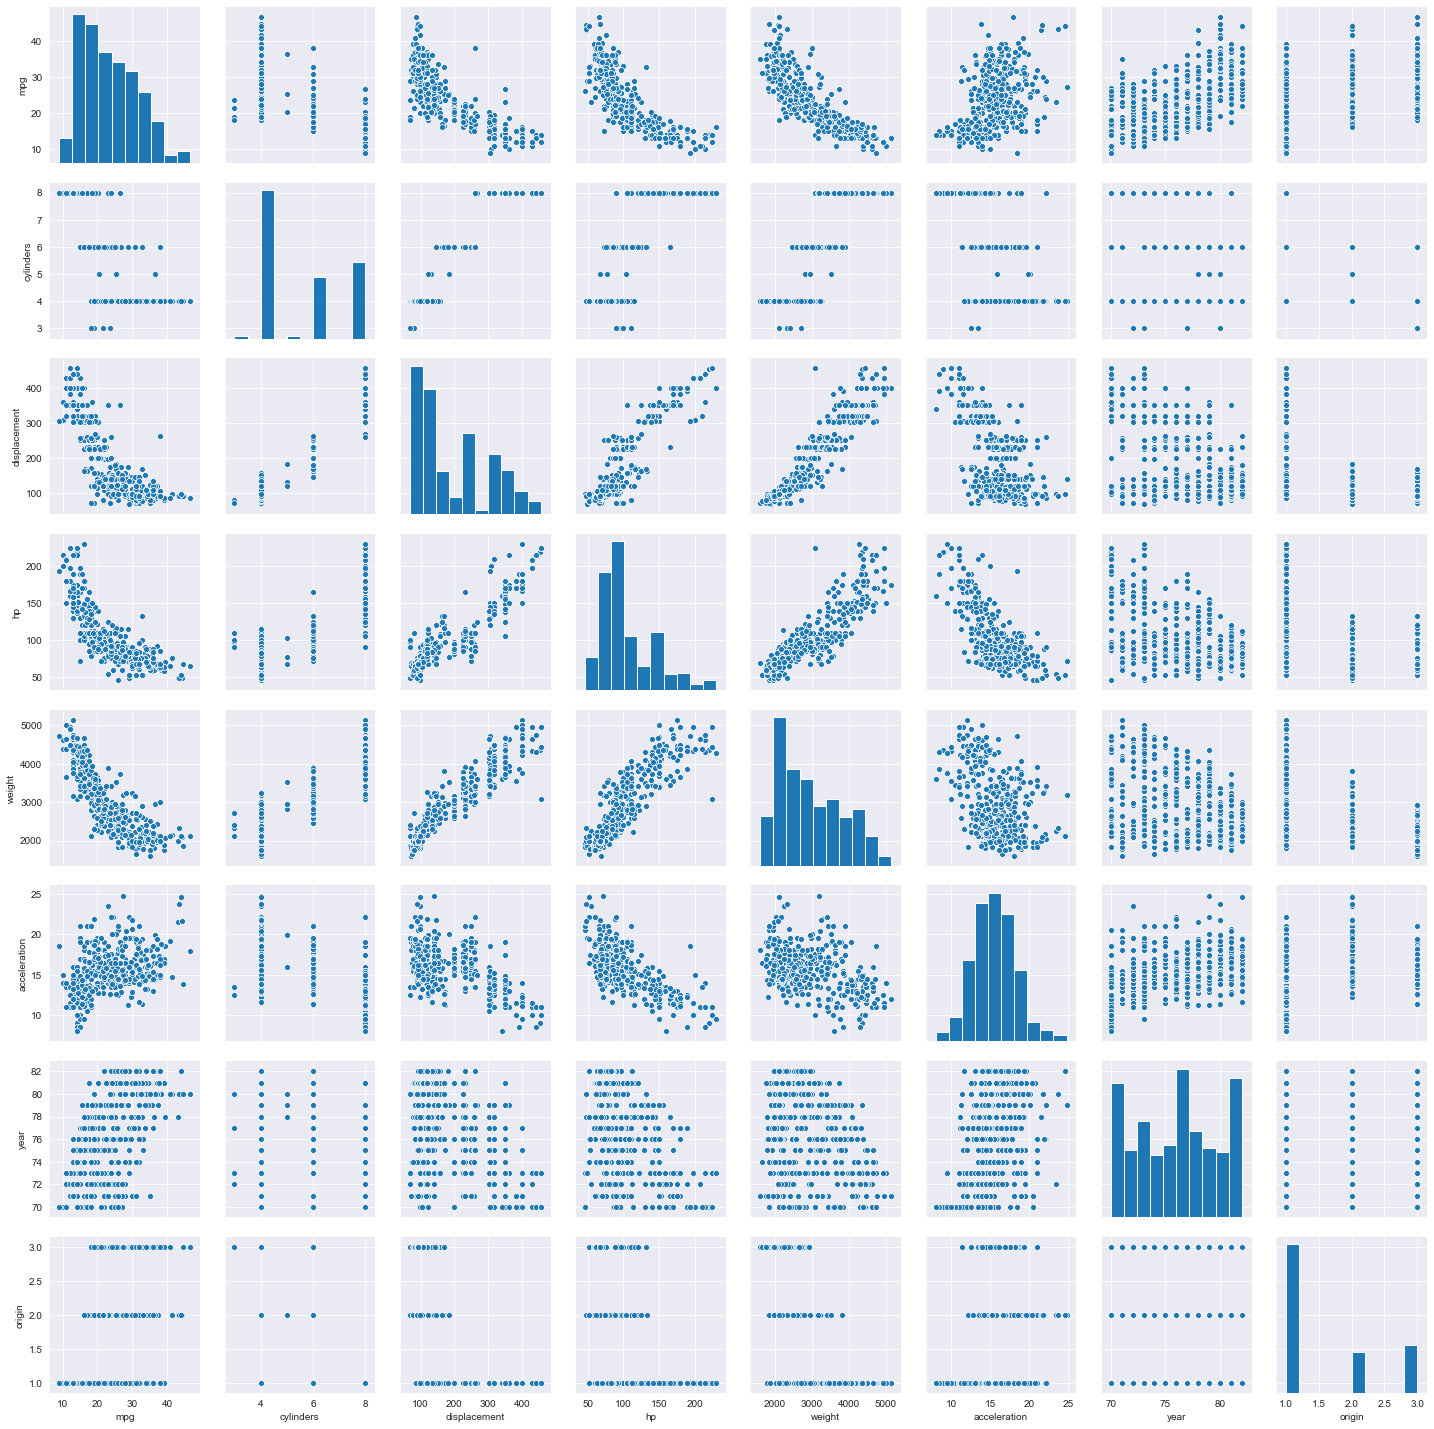

In [8]:
sns.pairplot(d);

The plot above is a pair plot.
It show the distribution of each column in the diagonal.
In the boxes outside the diagonal, we have a scatter plot of each column against each other column.
Note that boxes which are symmetric with respect to the diagonal, are just rotated version of each other.
For example, the plot of acceleration vs. hp is the rotated version of the plot of hp vs. acceleration.

Among the things we can see are some skewed distributions, e.g., for mpg or hp.
There are also some non-linear correlation between columns, e.g., between hp and mpg, while others look more linear, e.g., hp and weight.

In [9]:
dstd = (d - d.mean()) / d.std()

In [10]:
dstd.describe().round(2)

mpg  cylinders  displacement      hp  weight  acceleration    year  \
count  392.00     392.00        392.00  392.00  392.00        392.00  392.00   
mean    -0.00      -0.00         -0.00   -0.00    0.00          0.00    0.00   
std      1.00       1.00          1.00    1.00    1.00          1.00    1.00   
min     -1.85      -1.45         -1.21   -1.52   -1.61         -2.73   -1.62   
25%     -0.83      -0.86         -0.85   -0.77   -0.89         -0.64   -0.81   
50%     -0.09      -0.86         -0.41   -0.28   -0.20         -0.01    0.01   
75%      0.71       1.48          0.78    0.56    0.75          0.54    0.82   
max      2.97       1.48          2.49    3.26    2.55          3.36    1.63   

       origin  
count  392.00  
mean     0.00  
std      1.00  
min     -0.72  
25%     -0.72  
50%     -0.72  
75%      0.53  
max      1.77

Note how now all columns have mean 0 and standard deviation 1.

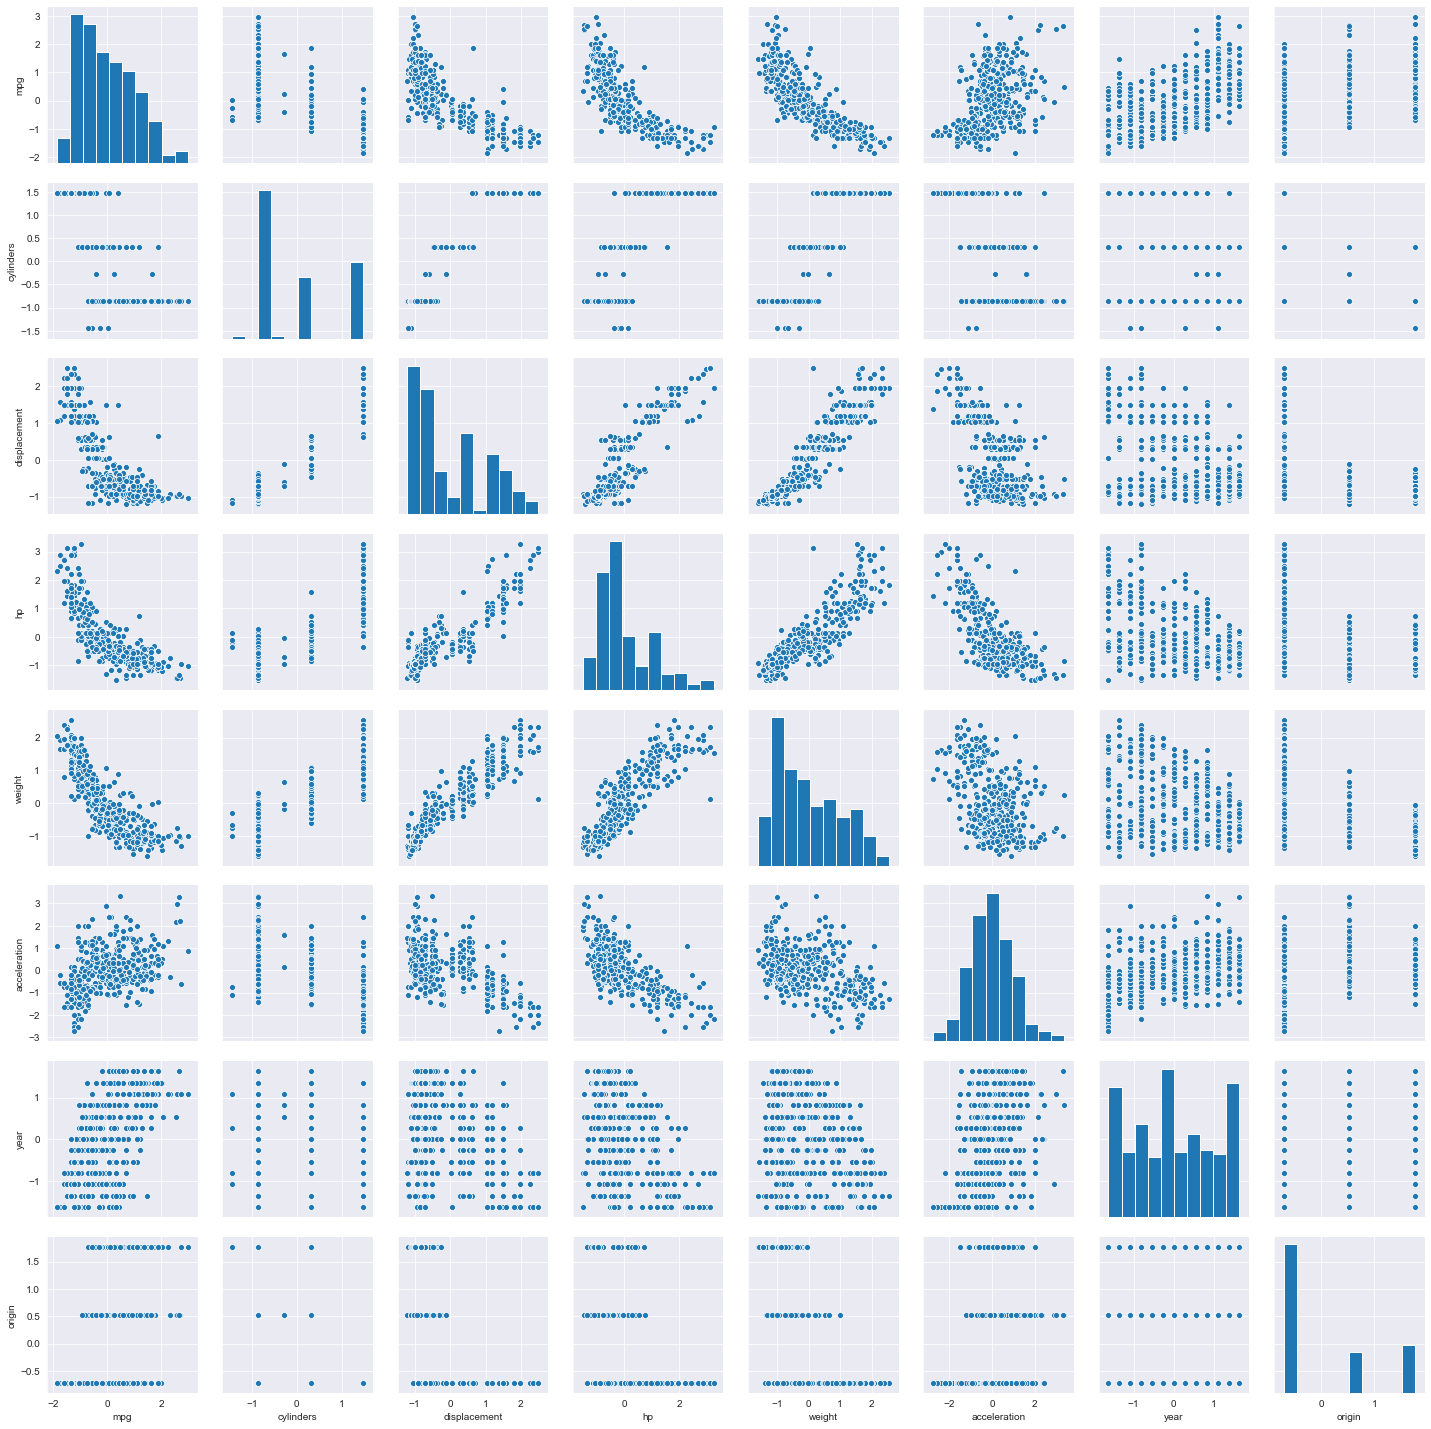

In [11]:
sns.pairplot(dstd);

As we mentioned before, the distributions and the mutual correlations between variables are left unchanged.
Indeed, the new pairplot has different scales in the $x$ and $y$ axes of each box, but the shapes are the same.

One more visualisation tool in our belt is that of a correlation matrix plot.
Instead of reading the correlation matrix as a big table, we display it color-coded, so that columns which are positively correlated are shaded in green, and columns which are negatively correlated are shaded in red.

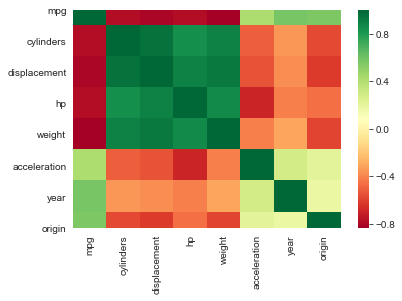

In [9]:
sns.heatmap(dstd.corr(), cmap = plt.cm.RdYlGn);

Note how elements in the diagonal have a correlation of $+1$: clearly each column is perfectly correlated with itself.
But there are other variables that show strong corelations, including the dependent variable `mpg`.

One last plot that I want to show involves discrete data, such as the `year` column.
Let's show how the value of `mpg` changes year over year (irrespective of the other features).
I suspect that cars became more efficient as time passed.
Note that here I use the original dataset, because I want to see the "real" value for column `year`.

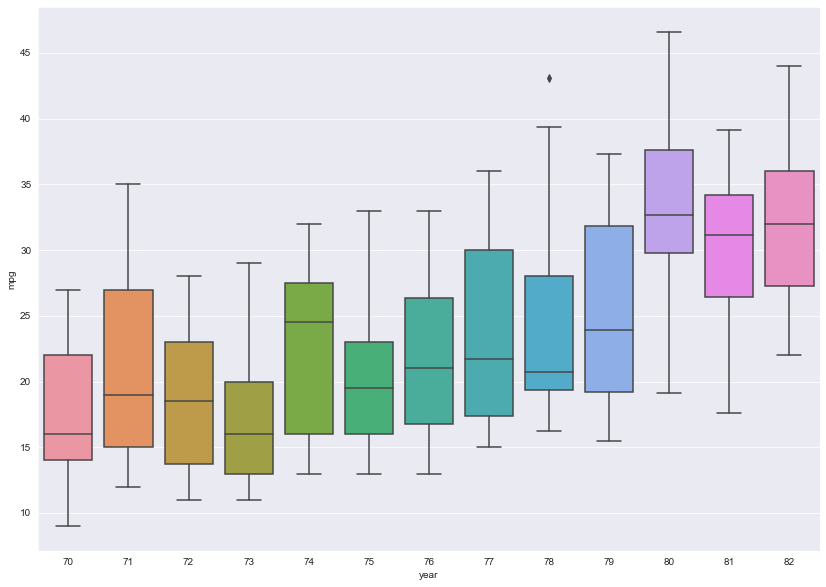

In [12]:
sns.boxplot(x = 'year', y = 'mpg', data = d);

### The train-test split

To split our data into train and test sets, we can use the `train_test_split` function from `sklearn`.
We first divide our dataset into the input independent variables ($X$) and the output label ($y$).

In [13]:
label_column = 'mpg'
feature_columns = [c for c in d.columns if c != label_column]
X = d[feature_columns].values
y = d[label_column].values

In [14]:
X.shape, y.shape

((392, 7), (392,))

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

With the code above, we have created our training set, with a random sample of 75% of the data.
The remaining 25% went to the test set.

### A note of warning: information leakage

You might have noticed that above, when splitting the data into training and test set, I used the original dataset: not the standardised one.
The reason is the following: the model should be completely blind to the data in the test set; training should only happen with data from the training set.
Now, if I standardised my features using all data, some information from the points in the test set would need to be used to perform the standardisation.
For example, to compute the mean over all data points, some of the terms in the sum would refer to data points in the test set.
This would violate the assumption that the model should not know *anything* about the test set.
Using information from the test set to manipulate data in the traning set (e.g., to standardise it) amounts to **leak information** from the test to the training set, and should be avoided.

What to do, then?
The answer is simple: we only standardise the training set.
Great, but after training our model will have parameters which make sense for data with zero mean and unit standard deviation... how do we use such a model on the test data, if we leave such test data untrasformed?
For example, the standardised values for `hp` go from -1.52 to 3.26, but the original values go from 46 to 230.
We cannot pass 230 as the value of the independent variable to a model which was trained with values close to zero: this large value would not make sense for our model, which was trained with standardised values.
Again, the solution is simple.
We apply a standardisation transformation to the test data, *but using the standardisation parameters of the training data*.
In this way, even the data transformation only depepnds on the training points and no information leakage is possible.

The easiest way to make sure that data transformation (in this case, standardisation) is applied correctly, is to use sklearn's pipelines.
In this case, we will create a pipeline with a `StandardScaler` followed by `LinearRegression`.
The pipeline is smart enough to train the scaler on the training data only.

### Evaluating the first model: linear regression

We now train a linear regression model on the training set, and calculate the MSE on the test set.
We will use the MSE value as a measure of quality (the lower, the better) of the model.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lin_model = make_pipeline(
    StandardScaler(),
    LinearRegression()
).fit(X_train, y_train)

In [17]:
# lin_model.intercept gives the intercept lambda_0
print(f"Intercept: {lin_model[1].intercept_:.4f}")

# lin_model.coef_ gives the other 7 coefficients lambda_1 ... lambda_7
for i, coef in enumerate(lin_model[1].coef_):
    print(f"Coefficient for {feature_columns[i]}: {coef:.4f}")

Intercept: 23.3524
Coefficient for cylinders: -0.6176
Coefficient for displacement: 1.2377
Coefficient for hp: -0.2437
Coefficient for weight: -5.4407
Coefficient for acceleration: 0.3671
Coefficient for year: 2.6420
Coefficient for origin: 0.9612


In [18]:
from sklearn.metrics import mean_squared_error

test_predictions = lin_model.predict(X_test)
lin_model_mse = mean_squared_error(y_test, test_predictions)

In [19]:
print(f"Linear regression model. Test MSE: {lin_model_mse:.4f}")

Linear regression model. Test MSE: 10.6268


### Evaluating the second model: quadratic regression

We repeat the same procedure as above, but now for a quadratic regression model.
The `sklearn` model we use is again `LinearRegression`, because quadratic regression can be interpreted as linear regression on an augmented features space.
For example, if $p=2$, a linear regression model is:
$$\hat{y} = \lambda_0 + \lambda_1 x_1 + \lambda_2 x_2$$
and a quadratic regression model is:
$$\hat{y} = \lambda_0 + \lambda_1 x_1 + \lambda_2 x_2 + \lambda_{11} x_1^2 + \lambda_{12} x_1 x_2 + \lambda_{22} x_2^2$$
But if we *create* new features $x_3 = x_1^2, x_4 = x_1 x_2, x_5 = x_2^2$, then we can see this last model as a linear regression model over $x_1, \ldots, x_5$:
$$\hat{y} = \lambda_0 + \lambda_1 x_1 + \lambda_2 x_2 + \lambda_3 x_3 + \lambda_4 x_4 + \lambda_5 x_5$$

When using `sklearn` this translates into first applying an input transformation akin to going from $\{x_1,x_2\}$ to $\{x_1, \ldots, x_5\}$ above; next, we use a linear model on the new inputs.
Combining two methods in sequence on the original input is again a perfect task for a pipeline.
So we will build a pipeline that standardises data, then adds the quadratic features, and then applies linear regression.

In [20]:
from sklearn.preprocessing import PolynomialFeatures

poly_model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = 2),
    LinearRegression()
).fit(X_train, y_train)

In [21]:
# poly_model[0] is the standardisation step
# poly_model[1] is the step creating polynomial features
# poly_model[2] is the LinearRegression model on the new space

poly_model[2].intercept_.round(4), poly_model[2].coef_.round(4)

(22.3404, array([ 0.    ,  1.5128, -0.7048, -1.281 , -4.6158,  0.1345,  2.4901,
         2.5811, -1.8112,  6.0561, -0.0107, -1.3961,  1.9895, -0.283 ,
         1.1177, -4.9818,  1.9885,  4.5644, -0.6478,  0.5565,  2.9152,
         0.5019, -2.5608,  0.2421,  0.3461,  0.4408,  0.2442, -0.2655,
        -0.609 , -1.1271,  0.3856,  0.7807,  1.5704,  0.6381,  0.2923,
        -0.1497]))

In [22]:
print("The quadratic model has {} parameters.".format(len(poly_model[2].coef_) + 1))

The quadratic model has 37 parameters.


In [23]:
test_predictions = poly_model.predict(X_test)
poly_model_mse = mean_squared_error(y_test, test_predictions)

In [24]:
print(f"Quadratic regression model. Test MSE: {poly_model_mse:.4f}")

Quadratic regression model. Test MSE: 8.6019


It seems that the quadratic regression model is performing better than the linear regression one.
Such a complex model, however, is prone to overfitting.
As we will see later on in this course, a remedy against complex models and overfitting is *regularisation*.

### Evaluating the third model: quadratic regression + LASSO

We have already mentioned that to perform regularisation we add a penalisation term $R(\Lambda)$ to the loss function (in this case, to the MSE), multiplied by a coefficient $\rho \in \mathbb{R}_+$.
The coefficient $\rho$ is a hyperparameter, which needs to be set by the user; that is, by us.
How to choose the proper $\rho$, then?
The choice of good hyperparameters is called *(hyper)parameter tuning*.

In this example, we will use the *Grid Search* method to find a good value for $\rho$.
The gist of grid search is: get a list of possible values for $\rho$, try all of them and return the one which performed best.
The method Grid Search uses to estimate the MSE corresponding to a given parameter $\rho$ is called *Cross-Validation*, and will be the topic of our next class.
For the moment, we will just consider `GridSearchCV` as a black box that performs hyperparameter tuning.

The code below finds a good value for $\rho$ in a log-space from $\rho = 10^{-3}$ to $\rho = 10^0 = 1$, trying 25 different values.
Note how, in sklearn, our parameter $\rho$ is actually called `alpha`.
You will also notice that I use `neg_mean_squared_error` as the metric to compare models.
The `neg_` part means "negative", i.e., we are using $-1 \cdot \text{MSE}$.
The reason is that `GridSearchCV` expects a metric of the *quality* of a model, i.e., the higher the metric, the better the model.
The MSE works the other way around: the lower the MSE, the better the model.
The easiest way to use the MSE in conjunction with `GridSearchCV`, then, is to just take its negative.

As a final remark, in the special case of LASSO regression, there is also a "short-cut" to determine the best value for $\rho$ without using `GridSearchCV`.
For more information, look at the documentation of `sklearn.linear_model.LassoCV`.
For didactic purposes, I decided not to use `LassoCV` here.

In [25]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

kfold = KFold(n_splits = 5, shuffle = True, random_state = 0)
polylasso_model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = 2),
    GridSearchCV(
        estimator = Lasso(max_iter = 10000), 
        param_grid = {
            'alpha': np.logspace(-3, 0, 25)
        },
        scoring = 'neg_mean_squared_error',
        iid = False,
        cv = kfold)
).fit(X_train, y_train)

# Note - come back to read this comment after we study cross-validation:
# sklearn is smart enough to apply StandardScaler inside GridSearchCV,
# to each training fold. You can see this by swapping make_pipeline and
# GridSearchCV and notice that you get the same model, with the same
# MSE: no data leakage. Example:
# polylasso_model = GridSearchCV(
#         estimator = make_pipeline(
#             StandardScaler(),
#             PolynomialFeatures(degree = 2),
#             Lasso(max_iter = 10000)),
#         param_grid = {
#             'lasso__alpha': np.logspace(-3, 0, 25)
#         },
#         scoring = 'neg_mean_squared_error',
#         iid = False,
#         cv = kfold
# ).fit(X_train, y_train)

What the code above says is that the third element of the pipeline, after creating the polynomial features, should not be a simple model.
Rather, it should be a whole set of models (one for each of the 25 values taken by $\rho$) and that we use Grid Search to decide which of these models to pick.
Fitting the pipeline will automatically run Grid Search and find the best value for $\rho$.
In this case, the value is:

In [26]:
polylasso_model[2].best_params_

{'alpha': 0.03162277660168379}

As we will soon find out (in the lecture about regularisation) a nice characteristic of LASSO is that it can set many regression coefficients to zero:

In [27]:
print(f"Intercept: {polylasso_model[2].best_estimator_.intercept_:.4f}")
for i, coef in enumerate(polylasso_model[2].best_estimator_.coef_):
    print(f"Coefficient #{i:2}: {coef:7.4f}")

Intercept: 21.2947
Coefficient # 0:  0.0000
Coefficient # 1:  0.0000
Coefficient # 2: -0.3217
Coefficient # 3: -1.4050
Coefficient # 4: -4.4976
Coefficient # 5: -0.0000
Coefficient # 6:  2.6075
Coefficient # 7:  1.0400
Coefficient # 8: -0.0000
Coefficient # 9:  0.0000
Coefficient #10:  0.0000
Coefficient #11:  0.5263
Coefficient #12:  0.6249
Coefficient #13: -0.0000
Coefficient #14:  0.5196
Coefficient #15:  0.0000
Coefficient #16:  0.0000
Coefficient #17:  1.0666
Coefficient #18:  0.0000
Coefficient #19:  0.0000
Coefficient #20:  0.8034
Coefficient #21:  0.0000
Coefficient #22:  0.0000
Coefficient #23: -0.0000
Coefficient #24: -0.0463
Coefficient #25:  0.0000
Coefficient #26:  0.4046
Coefficient #27:  0.0000
Coefficient #28: -0.0000
Coefficient #29:  0.0000
Coefficient #30:  0.2834
Coefficient #31:  0.6056
Coefficient #32:  1.2022
Coefficient #33:  0.5456
Coefficient #34:  0.2254
Coefficient #35: -0.0021


Finally, let's compute the MSE of our quadratic regression + LASSO model.

In [28]:
test_predictions = polylasso_model.predict(X_test)
polylasso_model_mse = mean_squared_error(y_test, test_predictions)

In [29]:
print(f"Quadratic regression + LASSO model. Test MSE: {polylasso_model_mse:.4f}")

Quadratic regression + LASSO model. Test MSE: 7.6899


So, to recap, these are the three estimates of the MSE of our models:

In [30]:
print(f"Linear regression model. Test MSE: {lin_model_mse:.4f}")
print(f"Quadratic regression model. Test MSE: {poly_model_mse:.4f}")
print(f"Quadratic regression + LASSO model. Test MSE: {polylasso_model_mse:.4f}")

Linear regression model. Test MSE: 10.6268
Quadratic regression model. Test MSE: 8.6019
Quadratic regression + LASSO model. Test MSE: 7.6899


It looks like the third model (quadratic regression with LASSO regularisation) is the best one, and it improves considerably the "basic" linear regression model.
Before using this model in production, let's remember that we should re-train it on the whole dataset:

In [31]:
final_lasso = polylasso_model[2].best_estimator_
final_model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = 2),
    final_lasso
).fit(X, y)

And now, we would be able to make predictions for cars that our model has never seen.
Curious to try?
I retrieved data about glorious 1983 Seat Marbella.
Let's see how our model fares at predicting its MPG.

In the following I juggled a bit between different units of measure, as I found data in international units but the model expects data in typically American units.

In [32]:
seat_marbella = [
    4,           # Cylinders
    899 * 0.061, # Displacement: 899 cc => cubic inches
    41,          # Horsepower
    680 * 2.20,  # Weight: 680 kg => pounds
    19.2,        # Acceleration: time to go from 0 to 100 kmph ~~ 0 to 60 mph
    83,          # Year: 1983
    2,           # Origin: 2 (Europe)
]
seat_marbella_lkm = 5.1 # Litres per 100 km
seat_marbella_mpg = (100 * 3.78) / (1.61 * seat_marbella_lkm) # litres/km => miles/gallon

In [33]:
predicted_mpg = final_model.predict([seat_marbella])

In [34]:
print("Seat Marbella 1983. Real mpg: {:.3f}, predicted MPG: {:.3f}".format(
    seat_marbella_mpg,
    predicted_mpg[0]))

Seat Marbella 1983. Real mpg: 46.036, predicted MPG: 46.234


Not bad at all!

![](../figures/marbella.jpg)

## Variance of the hold-out validation method

**The objective of splitting our data into training and test set is to obtain an estimate of the accuracy of the model (in this case using the MSE) on new data.**
Lacking a way to produce new data points at will, we have seen that we have to resort to doing the next-best thing: hiding some data from our model when training, and then using this hidden data as a proxy for new data.
Therefore, we hope that the MSE calculated on the test data is a good approximation of the "real" MSE of our model, when we will use it on brand new data.

But is this approximation actually good?
In other words: when we estimate the test MSE using the hold-out validation method, how strong is the influence of the random train-test split?
If **choosing a different training set gives us a very different model and a very different test MSE,** then looking at the test MSE is not very informative.
**Ideally, we would like our test MSE to be stable with respect to variations in the train-test split.**

We can check if this is the case for our example problem.
Let's repeat the train-test split 1000 times, train a given model on each of the 1000 training set, and estimate the test MSE on the corresponding test set.
Then, we can have a look at how the test MSEs are distributed.
For this experiment, I chose the quadratic regression + LASSO model, with parameter `alpha` fixed to the best value we estimated before.

In [35]:
model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = 2),
    Lasso(alpha = 0.0316, max_iter = 10000))
mses = list()

for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = i)
    model.fit(X_train, y_train)
    mses.append(mean_squared_error(y_test, model.predict(X_test)))

This is how the test MSEs are distributed:

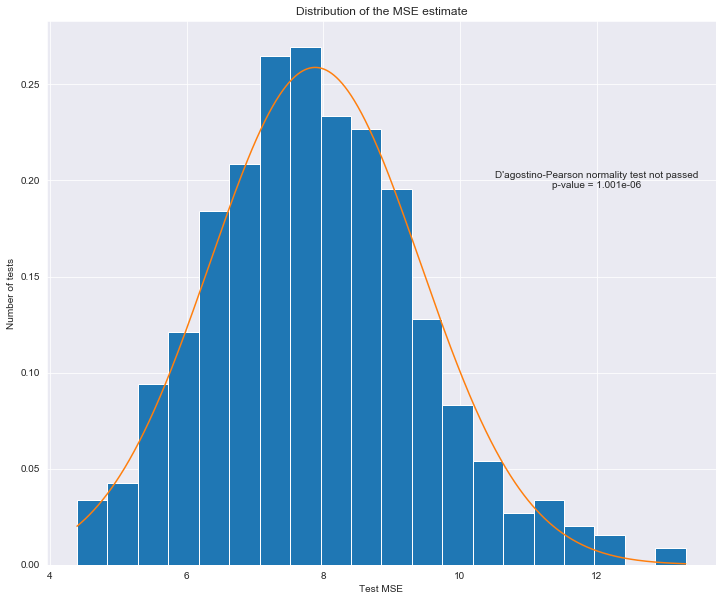

In [36]:
from scipy.stats import norm
from scipy.stats import normaltest

_, pvalue = normaltest(mses)
passed = '' if pvalue > 0.05 else 'not '
norm_x = np.linspace(min(mses), max(mses), 1000)

fig, ax = plt.subplots(figsize = (12, 10))
ax.hist(mses, bins = 20, density = True)
ax.plot(norm_x, norm.pdf(norm_x, np.mean(mses), np.std(mses)))
ax.set_xlabel('Test MSE')
ax.set_ylabel('Number of tests')
ax.set_title('Distribution of the MSE estimate')
ax.text(12, 0.2, "D'agostino-Pearson normality test {}passed\np-value = {:.4}".format(passed, pvalue), ha = 'center', va = 'center');

In [37]:
print("Mean test MSE: {:.3f}; standard deviation: {:.3f}".format(np.mean(mses), np.std(mses)))

Mean test MSE: 7.882; standard deviation: 1.541


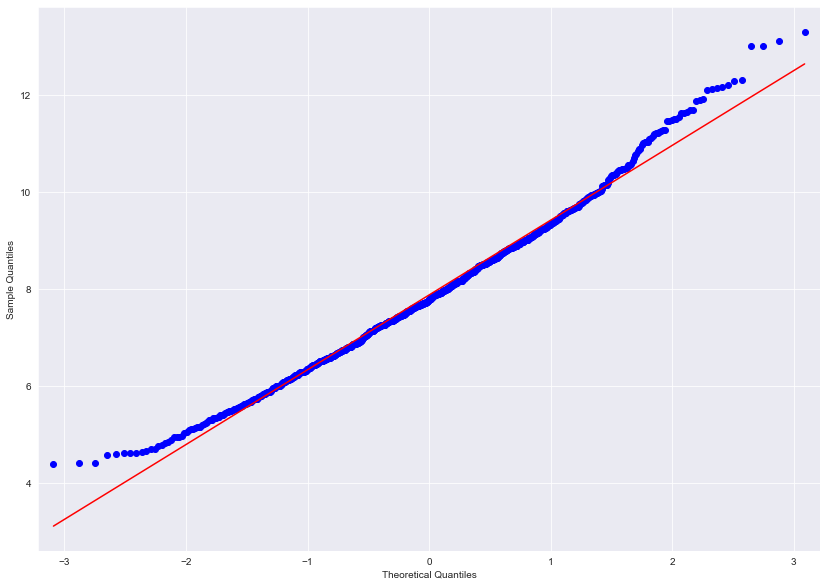

In [38]:
from statsmodels.graphics.gofplots import qqplot
qq = qqplot(np.array(mses), line='s')

In fact, it looks like the MSEs are **not** normally distributed.
Their standard deviation is also non-negligible.

From the chart above we can conclude that there is some variability on the estimate of the MSE, when using the holdout validation approach.
But we can also say something about the *bias* of the MSE estimate.
In fact, when we train our model on the training set, we only used 75% of the data (because we reserved the other 25% for testing).
Models normally learn better when exposed to more samples, because more data helps discriminating the true underlying relationship between inputs and outputs ($f$) from the noise.
Therefore, we can expect that the model we trained on 75% of the data will perform worse than the final model we re-trained on 100% of the data.
This means that the **MSE of the first model (trained on 75% of the data)** will likely be **higher** than the MSE of the second one (trained on 100% of the data), when applying these models to predict new, unseen data.
In other words, the **test MSE we obtain with the holdout validation method *overestimates* the true MSE of the model.**
In this case, we say that the estimation of the model's MSE given by the holdout validation method is **biased**.